# **To Do**

Go to File > Open in playground mode

**!!! Change Runtime to GPU !!!**

**Go to Runtime > Change runtime type > Hardware accelerator:GPU **

To run, go Runtime> Restart and run all

In [1]:
!git clone https://github.com/twpkevin06222/Liver-Segmentation-Project-.git medical_imaging

fatal: destination path 'medical_imaging' already exists and is not an empty directory.


In [2]:
!pip install nibabel

# Imports

In [3]:
import h5py
import os
import cv2
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers import Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
import numpy as np
import scipy.misc
import numpy.random as rng
from PIL import Image, ImageDraw, ImageFont
from sklearn.utils import shuffle
import nibabel as nib #reading nifti images
import math
import glob
import matplotlib.pyplot as plt
%matplotlib inline
#from read_data import load_images
from keras.layers.merge import concatenate
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Dependencies

In [4]:
import tensorflow as tf
import keras
print('Tensorflow version:', tf.__version__)
print('Keras version:', keras.__version__)

Tensorflow version: 1.12.0
Keras version: 2.2.4


---

# Data Preprocessing
Prepare data for input and data preprocessing

In [0]:
def three_to_two(path, label='FALSE'):
    ff = sorted(glob.glob(path))
    images =[]
    for f in range(len(ff)):
        a = nib.load(ff[f])
        a = a.get_data()
        for i in range(a.shape[2]):
            images.append(a[:,:,i])     
    images = np.asarray(images)
    #images = images.reshape(-1, 128,128, 1) # dimension to feed into the network
    return images

def min_max_norm(images):
    m = np.max(images)
    mi = np.min(images)
    images = (images - mi)/ (m - mi)
    return images

def label_outliers(img_labels):
    img_labels[img_labels>1]=1
    img_labels[img_labels<0]=0
    return img_labels

#Image for training 
images = three_to_two(path='medical_imaging/tmp/tmp_img/img_new/*')
x_data = min_max_norm(images)

#labels
img_labels = three_to_two(path='medical_imaging/tmp/tmp_img/img_new_label/*')
y_data = label_outliers(img_labels)

#Test Image
img_test = three_to_two(path='medical_imaging/tmp/tmp_img/test_img/*')
x_test = min_max_norm(img_test)

#Test Labels
label_test = three_to_two(path='medical_imaging/tmp/tmp_img/test_img_label/*')
y_test = label_outliers(label_test)

Plot data w.r.t labels

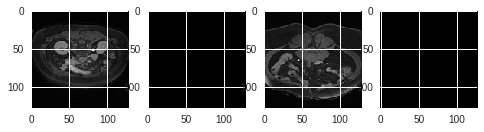

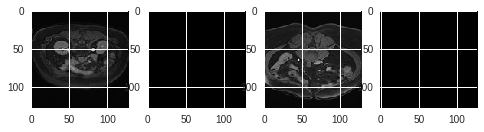

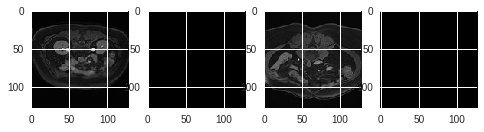

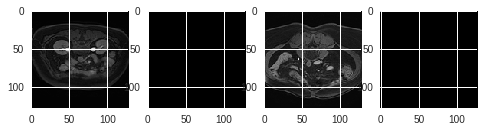

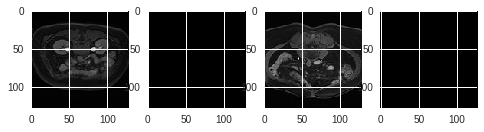

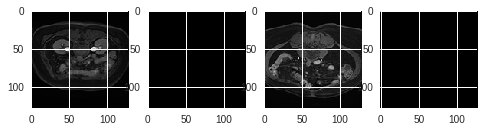

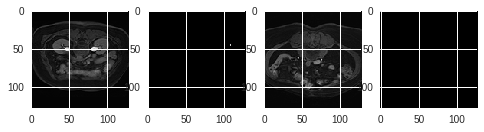

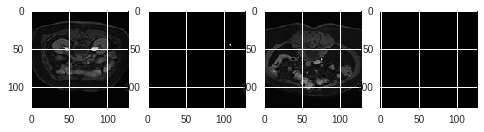

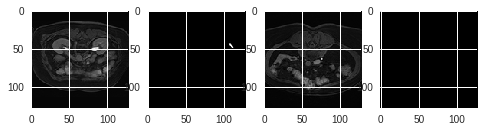

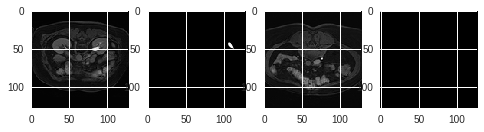

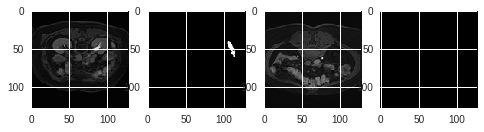

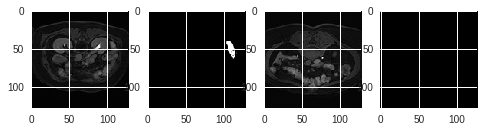

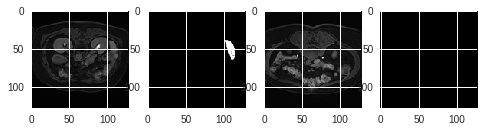

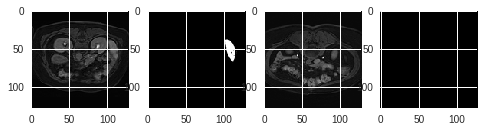

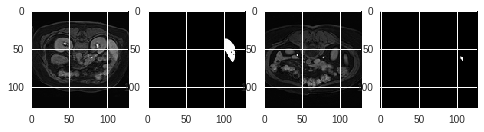

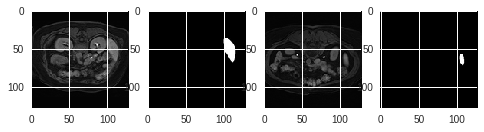

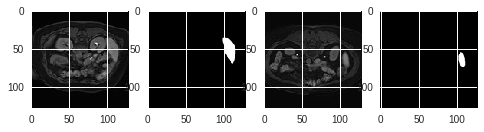

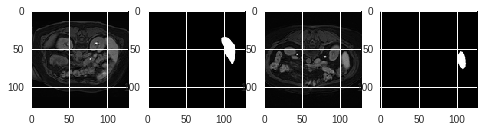

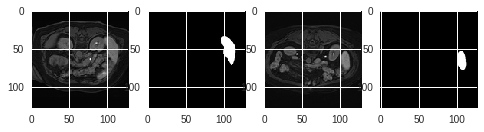

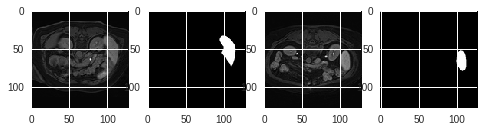

In [6]:
#show 1st 20 slices

for i in range(20):
    fig, ax = plt.subplots(1,4, figsize = (8,4))
    ax[0].imshow(x_data[i], cmap='gray')
    ax[1].imshow(y_data[i], cmap='gray')
    ax[2].imshow(x_test[i], cmap='gray')
    ax[3].imshow(y_test[i], cmap='gray')
    
plt.show()

Reshape input data to feed into the network with 
shape (depth*#image, width, height, channel)

In [7]:
x_data = x_data[:,:,:,np.newaxis] # same as reshape (-1,128,128,1)
y_data = y_data[:,:,:,np.newaxis]
x_test = x_test[:,:,:,np.newaxis]
y_test = y_test[:,:,:,np.newaxis]

print('Dimension for training data:', x_data.shape)
print('Dimension for training data labels:', y_data.shape)
print('Dimension for test data:', x_test.shape)
print('Dimension for test data labels:', y_test.shape)

Dimension for training data: (3036, 128, 128, 1)
Dimension for training data labels: (3036, 128, 128, 1)
Dimension for test data: (735, 128, 128, 1)
Dimension for test data labels: (735, 128, 128, 1)


Split data: 80% Training, 20% Validation

In [0]:
from sklearn.utils import shuffle

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.2, random_state =42)
x_test, y_test = shuffle(x_test, y_test, random_state= 42)

Approximation of Dice Coefficient

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [0]:
input_layer = Input(shape=x_train.shape[1:]) #Input(shape = (x, y, inChannel))

---

# Network Topology

Toy Model 01 

In [0]:
def conv_block(x_in, filters, batch_norm, kernel_size=(3,3)):
    x = Conv2D(filters, kernel_size, padding='same')(x_in)
    if batch_norm=='TRUE':
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    if batch_norm=='TRUE':
        x = BatchNormalization()(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def conv_2d(x_in, filters, batch_norm, kernel_size=(3,3),acti ='relu'):
    x = Conv2D(filters, kernel_size, padding='same')(x_in)
    if batch_norm=='TRUE':
        x=BatchNormalization()(x)
    x= Activation(acti)(x)
    return x
    
def pool(x_in, pool_size=(2, 2), type='Max'):
    if type=='Max':
        p = MaxPooling2D(pool_size)(x_in)
    return p

def up(x_in, filters, merge, batch_norm, size=(2,2)):
    u = UpSampling2D(size)(x_in)
    conv = conv_block(u, filters, batch_norm)
    merge=concatenate([merge, conv],axis=-1)
    return merge
    
def Unet_01(input_layer):
    conv1 = conv_block(input_layer, filters=16, batch_norm='TRUE')
    pool1 = pool(conv1)
    
    conv2 = conv_block(pool1, filters=32, batch_norm='TRUE')
    pool2 = pool(conv2)
    
    conv3 = conv_block(pool2, filters=32, batch_norm='TRUE')
    pool3 = pool(conv3)
    
    conv4 = conv_block(pool3, filters=64, batch_norm='TRUE')
    pool4 = pool(conv4)
    
    conv5 = conv_2d(pool4, filters=128, batch_norm='TRUE')
    
    up1 = up(conv5,filters=128, merge=conv4, batch_norm='TRUE')
    conv6 = conv_2d(up1, filters=128, batch_norm='TRUE')
    
    up2 = up(conv6, filters=128, merge=conv3, batch_norm='TRUE')
    conv7 = conv_2d(up2, filters=128, batch_norm='TRUE')
    
    up3 = up(conv7, filters=64, merge=conv2, batch_norm='TRUE')
    conv8 = conv_2d(up3, filters=64, batch_norm='TRUE')
    
    up4 = up(conv8, filters=32, merge=conv1, batch_norm='TRUE')
    conv9 = conv_2d(up4, filters=32, batch_norm='TRUE')
    
    conv10 = conv_2d(conv9, filters=1, batch_norm='FALSE', acti='sigmoid')
    
    output_layer = conv10
    model = Model(input_layer, output_layer)
    
    return model
    

Swtich for different network

In [0]:
model = Unet_01(input_layer)

Data Augmentation

In [0]:
def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(x_train, x_train, batch_size, seed=42)
    mask_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(y_train, y_train, batch_size, seed=42)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

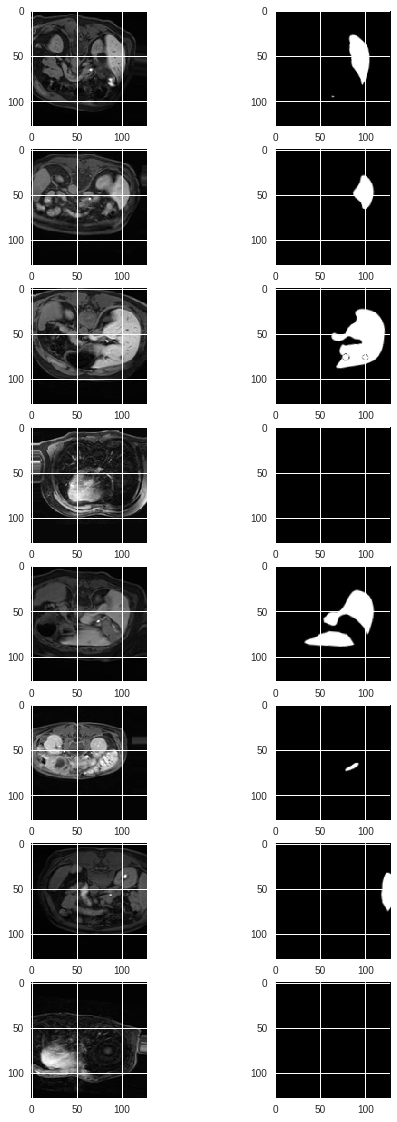

In [14]:
image_batch, mask_batch = next(my_generator(x_train, y_train, 8))
fix, ax = plt.subplots(8,2, figsize=(8,20))
for i in range(8):
    ax[i,0].imshow(image_batch[i,:,:,0], cmap='gray')
    ax[i,1].imshow(mask_batch[i,:,:,0], cmap='gray')
plt.show()

In [0]:
model.compile(optimizer=Adam(1e-4), loss= dice_coef_loss, metrics=[dice_coef])

Parameters

In [16]:
# def steps_per_epoch(sample, batch_size):
#     a = int(np.floor(sample/batch_size))
#     if a<200:
#         return 200
#     else:
#         return a
    
sample = len(x_data)
batch_size = 64
epochs = 20
steps_per_epoch = 200
#steps_per_epoch = int(np.floor(sample/batch_size))
#steps_per_epoch = steps_per_epoch(sample, batch_size)

print('Step per epoch: ', steps_per_epoch)

Step per epoch:  200


Set checkpoint

In [0]:
from keras.callbacks import LearningRateScheduler
weight_saver = ModelCheckpoint('seg.h5', monitor='val_dice_coef', 
                                              save_best_only=True, save_weights_only=True)

lr_decay = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)

In [0]:
from keras.callbacks import TensorBoard
import time

model_dir = 'logs/{}'.format(time.strftime("%H"+"%M"))
tensorboard = TensorBoard(log_dir= model_dir, histogram_freq=epochs, batch_size=batch_size, write_graph=True, 
                          write_grads=False, write_images=True, embeddings_freq=0, 
                          embeddings_layer_names=None, embeddings_metadata=None, 
                          embeddings_data=None, update_freq='epoch')

write_time = time.strftime("%H"+"%M")

---

In [19]:
!/opt/bin/nvidia-smi

Tue Dec 18 17:08:36 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    56W / 149W |    117MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Training

In [20]:
hist = model.fit_generator(my_generator(x_train, y_train, batch_size),
                           steps_per_epoch = steps_per_epoch,
                           validation_data = (x_val, y_val),
                           epochs=epochs, verbose=1,
                           callbacks = [weight_saver, lr_decay])

Epoch 1/20
200/200 [==============================] - 164s 818ms/step - loss: 0.1522 - dice_coef: 0.8478 - val_loss: 0.0667 - val_dice_coef: 0.9333
Epoch 2/20
200/200 [==============================] - 144s 720ms/step - loss: 0.0558 - dice_coef: 0.9442 - val_loss: 0.0656 - val_dice_coef: 0.9344
Epoch 3/20
200/200 [==============================] - 144s 719ms/step - loss: 0.0477 - dice_coef: 0.9523 - val_loss: 0.0496 - val_dice_coef: 0.9504
Epoch 4/20
200/200 [==============================] - 144s 719ms/step - loss: 0.0436 - dice_coef: 0.9564 - val_loss: 0.0487 - val_dice_coef: 0.9513
Epoch 5/20
200/200 [==============================] - 144s 719ms/step - loss: 0.0410 - dice_coef: 0.9590 - val_loss: 0.0497 - val_dice_coef: 0.9503
Epoch 6/20
200/200 [==============================] - 144s 721ms/step - loss: 0.0391 - dice_coef: 0.9609 - val_loss: 0.0363 - val_dice_coef: 0.9637
Epoch 7/20
200/200 [==============================] - 144s 720ms/step - loss: 0.0385 - dice_coef: 0.9615 - val_l

In [0]:
model.load_weights('seg.h5')

---

# Results  

Learning Rate Plot

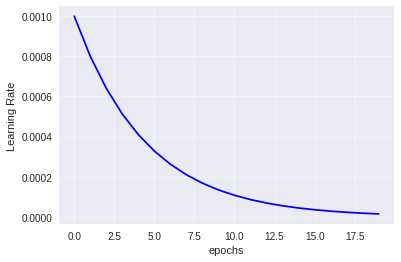

In [22]:
plt.plot(hist.history['lr'], color='b')
plt.xlabel("epochs")
plt.ylabel("Learning Rate")
plt.grid(linestyle='dotted')
plt.show()

***

Loss and Dice Coefficient Plot

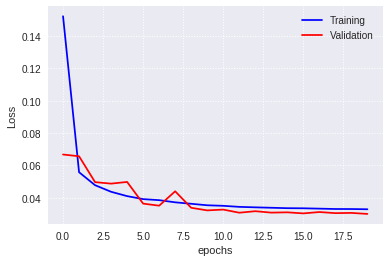

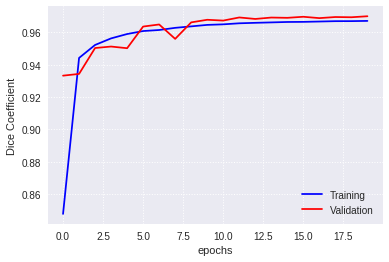

In [23]:
plt.plot(hist.history['loss'], color='b', label='Training')
plt.plot(hist.history['val_loss'], color='r', label='Validation')
plt.legend(loc='upper right')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.grid(linestyle='dotted')
plt.show()

plt.plot(hist.history['dice_coef'], color='b', label='Training')
plt.plot(hist.history['val_dice_coef'], color='r', label='Validation')
plt.xlabel("epochs")
plt.ylabel("Dice Coefficient")
plt.legend(loc='lower right')
plt.grid(linestyle='dotted')
plt.show()

In [24]:
# To run tensorboard
print('To view tensorboard, put this in your command line: \n tensorboard --log=logs/{}/'.format(write_time))

To view tensorboard, put this in your command line: 
 tensorboard --log=logs/1708/


In [25]:
!rm -rf ngrok-stable-linux-amd64.zip
!rm -rf ngrok
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
#!rm -f log/*   # Delete this if you want to keep the logs of the old runs
LOG_DIR = 'logs/{}'.format(write_time)
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2018-12-18 17:57:10--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.54.84.112, 54.152.127.232, 52.87.35.92, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.54.84.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  18.3MB/s    in 0.3s    

2018-12-18 17:57:10 (18.3 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
http://96f7c8e8.ngrok.io


In [26]:
test_eval = model.evaluate(x_test, y_test, verbose=1, batch_size = batch_size)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

735/735 [==============================] - 4s 5ms/step
Test loss: 0.08395281300252798
Test accuracy: 0.916047186997472


---

# Prediction

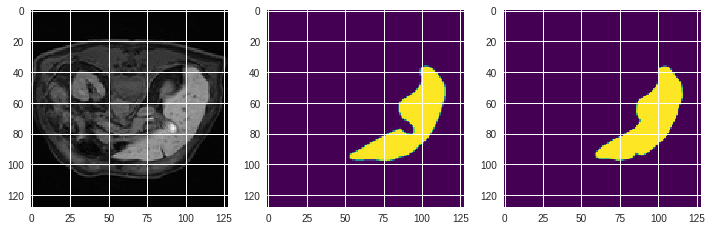

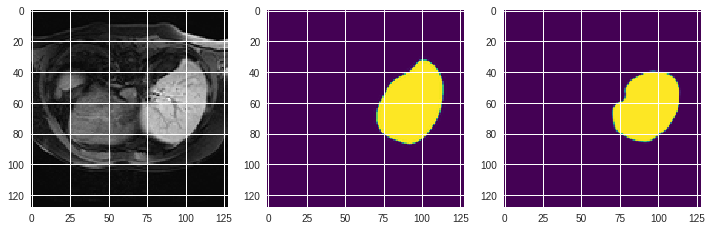

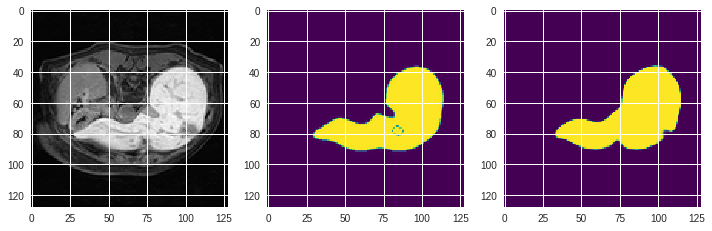

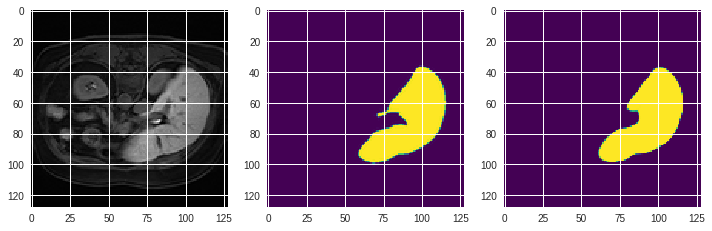

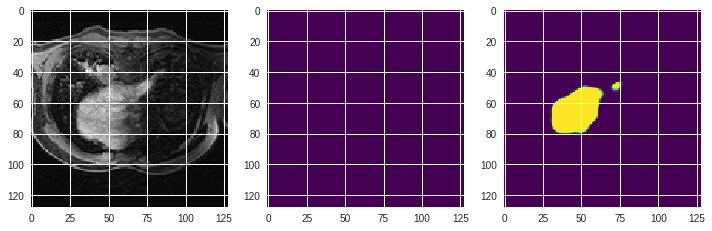

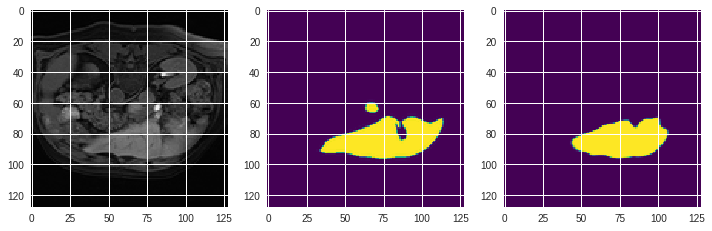

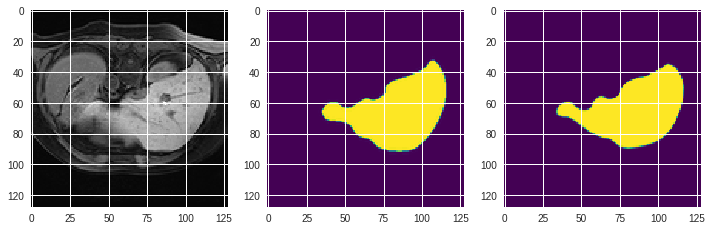

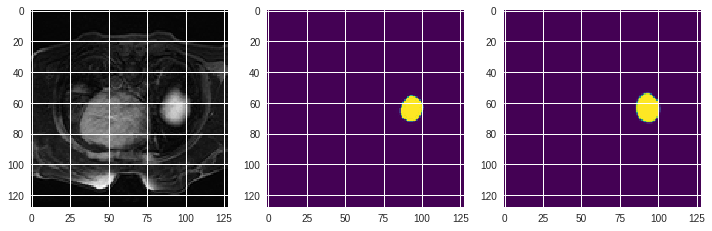

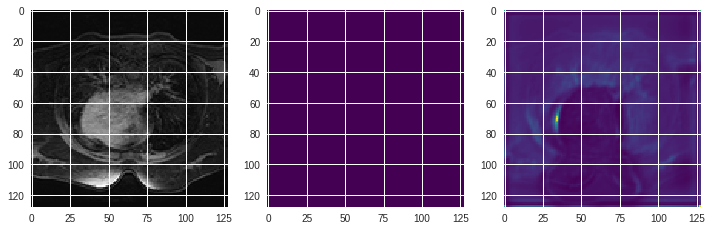

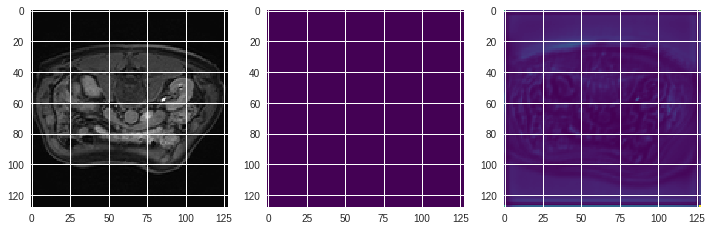

In [27]:
y_pred = model.predict(x_test)
for i in range(0,20,2):
    fig, ax = plt.subplots(1,3,figsize=(12,6))
    ax[0].imshow(x_test[i,:,:,0], cmap='gray')
    ax[1].imshow(y_test[i,:,:,0], cmap='viridis')
    ax[2].imshow(y_pred[i,:,:,0], cmap='viridis')
plt.show()

---

# Appendix

In [28]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

# Reference

*   https://www.kaggle.com/toregil/a-lung-u-net-in-keras 
*   https://github.com/jocicmarko/ultrasound-nerve-segmentation

